<a href="https://colab.research.google.com/github/colzh/ms-drug-discovery/blob/main/Generative_Ligand_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Useful links:
# https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles
# https://machinelearningmastery.com/gentle-introduction-generative-long-short-term-memory-networks/
# https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/

In [42]:
# Import libraries

import os
import sys
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import heapq

from sklearn.decomposition import PCA
from google.colab import files
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from tqdm import tqdm
from numpy.random import seed
seed(3)

# Install rdkit
!pip install rdkit-pypi==2021.9.4
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, Lipinski, AllChem, Fragments

# Load Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(3)

######### !!!!!! Upload Kaggle API key as kaggle.json before running this cell !!!!!!!! ############# https://www.kaggle.com/general/74235
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download kaggle dataset
!kaggle datasets download art3mis/chembl22

# Unzip kaggle dataset
import zipfile
with zipfile.ZipFile('chembl22.zip', 'r') as f:
    f.extractall('data')

mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [43]:
print(tf.__version__)
print(rdkit.__version__)

2.12.0
2021.09.4


In [44]:
# Load SMILES strings for training

with open('data/chembl_22_clean_1576904_sorted_std_final.smi') as f: # Read SMI file into list
  smiles = f.readlines()
smiles = [item.split('\t')[0] for item in smiles] # Split by linebreak

n = 500000          # Size of train + val set
min_length = 0      # Lower limit on length of SMILES sequence in train set
max_length = 100    # Upper limit on length of SMILES sequence in train set
smiles = [smi for smi in smiles if len(smi) <= max_length and len(smi) >= min_length]

print(f'Min length SMILES in data: {min_length}')
print(f'Max length SMILES in data: {max_length}')

# Load indices of SMILES strings
if os.path.exists("indices.npy"):
  print(f'Loading saved indices...')
  indices = np.load("indices.npy")
else:
  print(f'Sampling new indices...')
  indices = random.sample(range(len(smiles)), n)
  np.save("indices", indices)
  files.download('indices.npy')
smiles = [smiles[i] for i in indices]

# Tokenizer dictionary
unique_chars = list(set(''.join(smiles)))  # Get all unique characters in SMILES list
unique_chars.sort()
char_to_num = {char:i + 2 for i, char in enumerate(unique_chars)}  # Assign each unique char to a number
char_to_num['!'] = 0 # Add start token to dict
char_to_num['E'] = 1 # Add end token to dict

# Untokenizer dictionary
num_to_char = {v: k for k, v in char_to_num.items()}
vocab_size = len(num_to_char.items()) # Number of unique characters in vocab

print(f'{vocab_size} characters in dictionary.')

Min length SMILES in data: 0
Max length SMILES in data: 100
Loading saved indices...
39 characters in dictionary.


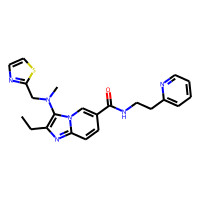

In [45]:
display(Draw.MolsToGridImage([Chem.MolFromSmiles(random.choice(smiles))], molsPerRow=1)) # Randomly draw a molecule from dataset

In [46]:
# Define functions to process dataset before loading into model

# One-hot encode SMILES string using tokenizer dictionary
def one_hot_encode(smi, to_length = max_length + 2):
  # Input: smile string
  # Output: np array with shape (to_length, vocab_size) including start and end tokens

  result = np.zeros((to_length, vocab_size), dtype = np.uint8) # Initialize results array
  result[0, char_to_num['!']] = 1  # Create start token vector

  for i, char in enumerate(smi):
    result[i + 1, char_to_num[char]] = 1  # Set appropriate element to 1
  result[(i + 2):, char_to_num['E']] = 1  # Create end token vectors, end-padded to to_length

  return(result)

# One-hot decode encoded SMILES array using untokenizer array
def one_hot_decode(array):
  # Input: encoded SMILES array
  # Output: SMILES string

  result = '' # Initialize SMILES string

  for item in array:
    item = list(item)
    index = item.index(1)
    result += (num_to_char[index]) # Add appropriate character to result

  result = result.replace('!', '') # Remove start token
  result = result.split('E')[0] # Truncate result at first end token

  return result

# Convert softmax array output of model into one-hot array
def softmax_to_one_hot(array, temp):
  # Input: softmax array with dimensions (max_length + 1, len(vocab_size))
  # Output: one-hot array where largest softmax value is in each row

  result = np.zeros(array.shape, dtype = np.uint8) # Initialize restuls array

  for i, row in enumerate(array):
    with np.errstate(divide='ignore'):
      row_with_temp = np.exp(np.log(row)/temp)/np.sum(np.exp(np.log(row)/temp)) # Calculate sampling probabilities for random variation
    result[i, np.random.choice(range(len(row)), p = row_with_temp)] = 1 # Set sampled index to 1

  return result

In [47]:
# # Create training and validation sets for model

# if os.path.exists('train_indices.npy'): # Load saved datasets
#   print(f'Loading saved train indices...')
#   train_indices = np.load('train_indices.npy')
# else:
#   # Split train and val sets
#   # Select random indices for train and val sets
#   train_indices = random.sample(range(len(smiles)), int(0.9 * len(smiles)))

#   # Save train indices
#   np.save('train_indices', train_indices)

# val_indices = list(set(range(len(smiles))) - set(train_indices))
# train_smiles = [smiles[i] for i in tqdm(train_indices) if Chem.MolFromSmiles(smiles[i])] # filter for smiles compatible with rdkit
# val_smiles = [smiles[i] for i in tqdm(val_indices) if Chem.MolFromSmiles(smiles[i])] # filter for smiles compatible with rdkit
# train_mols = [Chem.MolFromSmiles(smile) for smile in tqdm(train_smiles)]

# # Create one-hot-encoded datasets
# X_train = np.array([one_hot_encode(smile)[:-1] for smile in tqdm(train_smiles)]) # Contains sequence + start token
# X_val = np.array([one_hot_encode(smile)[:-1] for smile in tqdm(val_smiles)]) # Contains sequence + start token
# y_train = np.array([one_hot_encode(smile)[1:] for smile in tqdm(train_smiles)]) # Contains sequence + end token
# y_val = np.array([one_hot_encode(smile)[1:] for smile in tqdm(val_smiles)]) # Contains sequence + end token

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)

In [48]:
# Build model

def build_model(model_name = None,
                recurrent_unit_size = 256,
                latent_size = 256,
                epochs = 20,
                batch_size = 256,
                noise_sd = 0.01,
                latent_activation = 'relu',
                verbose = 1):

  if os.path.exists(f'{model_name}.h5'):
    print('Loading saved model...')
    model = tf.keras.models.load_model(f'{model_name}.h5')
    print(model.summary())

    return model, None

  else:
    # Encoder layers
    input = Input(shape = (None, vocab_size), name = 'input')
    state = GRU(recurrent_unit_size, name = 'encoder_pre')(input) # GRU state and GRU output are the same
    latent = Dense(latent_size, name = 'encoder', activation = latent_activation)(state)
    latent_noise = tf.keras.layers.GaussianNoise(noise_sd)(latent) # Gaussian layer to make decoder more robust to small deviations in latent vector
    state = Dense(recurrent_unit_size, name = 'decoder_pre', activation = 'relu')(latent_noise)

    # Decoder layers
    decoder = GRU(recurrent_unit_size, return_sequences = True, name = 'decoder')(input, initial_state = [state]) # return_sequences set as True to return SMILES sequence
    output = Dense(vocab_size, activation = 'softmax', name = 'output')(decoder)

    # Build model
    model = Model(inputs = input, outputs = output)

    # Compile model
    model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['acc'])
    print(model.summary())

    # Train model
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose = verbose, validation_data = (X_val, y_val))

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize = (18, 6))
    fig.tight_layout()

    for i, metric in enumerate(['acc', 'loss']):
      axs[i].plot(history.history[metric], label='train')
      axs[i].plot(history.history[f'val_{metric}'], label='val')
      axs[i].set_title(metric.upper())
      axs[i].set_ylabel(metric)
      axs[i].set_xlabel('epoch')
      axs[i].legend()

    # Save model
    model.save(f'{model_name}.h5')

    return model, history.history

In [49]:
# Define encoder and decoder models

# Convert SMILES string to latent vector
def smile_to_latent(smile, model):
  # Input: SMILES string or list of strings
  # Output: latent vector(s) in an array of dimensions (len(smile), latent_size)

  ohsmile = []

  # One-hot encode SMILES string or list of strings
  if isinstance(smile, str):
    ohsmile.append(one_hot_encode(smile, max_length + 2))
  else:
    for smi in smile:
      ohsmile.append(one_hot_encode(smi, max_length + 2))

  ohsmile = np.array(ohsmile)

  # Define encoder model
  encoder_model = Model(inputs = model.get_layer('input').input, outputs = model.get_layer('encoder').output)

  # Predict latent vector(s) from encoder model
  latent_vec = encoder_model.predict(ohsmile[:, :-1, :], verbose = 0)

  return latent_vec

# Convert latent vector to SMILES string
def latent_to_smile(latent_vec, temp, num_attempts, model):
  # Input: latent vector, sampling temperature, num_attempts
  # Output: SMILES string

  # Convert latent vector to a size compatible with decoder
  def latent_to_state(latent_vec, model):
    # Input: latent vector of size latent_size
    # Output: latent vector of size recurrent_unit_size

    input = Input(shape = (model.get_layer('encoder').output_shape[-1]))
    latent = model.get_layer('decoder_pre')(input)

    process_model = Model(inputs = input, outputs = latent)
    latent_vec_processed = process_model.predict(latent_vec, verbose = 0)

    return latent_vec_processed

  # Define decoder model
  decoder_input = Input(shape = (1, vocab_size), batch_size = 1, name = 'input')
  decoder = GRU(model.get_layer('encoder_pre').output_shape[-1], return_sequences = True, name = 'decoder', stateful = True)(decoder_input) # Stateful model because one char inputted at a time, and the chars of a sequence are related. In training several molecules are processed at a time so there is no need to preserve the states from the previous *independent* SMILES string.
  output = model.get_layer('output')(decoder)
  decoder_model = Model(decoder_input, output)

  decoder_model.get_layer('decoder').set_weights(model.get_layer('decoder').get_weights()) # Transfer weights from trained model because layer is redefined

  # Use decoder model to generate SMILES string from latent_vec
  smiles = []
  for i in range(num_attempts):
    # Predict SMILES string one character at a time

    decoder_model.get_layer('decoder').reset_states(states = latent_to_state(latent_vec, model)) # Pulling the states from convertor_model (resets_states stuffs the state numpy arrays into the LSTM layer)

    # Create start token to feed into model
    vec = np.zeros(vocab_size, dtype = np.uint8)
    vec[char_to_num['!']] = 1
    result = [vec] # Initialize results list
    vec = np.expand_dims(np.expand_dims(np.array(vec), 0), 0) # Make vec 3D to keep decoder model happy

    while np.argmax(np.expand_dims(result[-1], 0)) != char_to_num['E']:
      vec = np.expand_dims(softmax_to_one_hot(decoder_model.predict(vec, verbose = 0)[0], temp = temp), 0)
      result.append(vec[0][0])

    smiles.append(one_hot_decode(result))

  return smiles

In [50]:
# Define seed and random generation functions

# Call latent_to_smile multiple times from mutated versions of a latent seed
def generate_around(name, latent_seed, sd, model, num_attempts, num_attempts_per_latent, temp):
  # Input: Latent seed vector and standard deviation of permitted mutation (sd = 0 means no mutation)
  # Output: SMILES string

  num_success = 0
  valid_smiles = []
  valid_mols = []
  latent_size = model.get_layer('encoder').output_shape[-1]

  with open(name, "w") as file:
    pass

  for i in tqdm(range(num_attempts)):

    # Mutate seed
    mutated_latent_seed = latent_seed + sd * np.random.randn(latent_size)

    # Convert to smiles
    smiles = latent_to_smile(mutated_latent_seed, temp = temp, num_attempts = num_attempts_per_latent, model = model)

    for smile in smiles:
      # Check if smile valid
      molecule = Chem.MolFromSmiles(smile)
      if molecule:
        valid_smiles.append(smile)
        valid_mols.append(molecule)
        num_success += 1

        with open(name, 'r') as f:
          lines = f.readlines()

          if smile not in lines:
            with open(name, 'a') as f:
                f.writelines(smile + ",\n")

  # Calculate success rate
  success_rate = num_success/(num_attempts * num_attempts_per_latent)

  return num_success, success_rate, valid_smiles, valid_mols

# Call latent_to_smile multiple times from random latent seeds
def generate_random(span, model, num_attempts, num_attempts_per_latent, temp):

  num_success = 0
  valid_smiles = []
  valid_mols = []

  latent_size = model.get_layer('encoder').output_shape[-1]

  with open("random_ligands.txt", "w") as file:
    pass

  for i in tqdm(range(num_attempts)):
    # Generate random latent seed uniformly between 0 and 1
    latent_seed = np.random.uniform(low = span[0], high = span[1], size = (1, latent_size))

    # Get smile strings from seed
    smiles = latent_to_smile(latent_seed, temp = temp, num_attempts = num_attempts_per_latent, model = model)

    for smile in smiles:
      # Check if smile valid
      molecule = Chem.MolFromSmiles(smile)
      if molecule:
        valid_smiles.append(smile)
        valid_mols.append(molecule)
        num_success += 1

        with open(f'random_ligands.txt', 'r') as f:
          lines = f.readlines()

          if smile not in lines:
            with open(f'random_ligands.txt', 'a') as f:
                f.writelines(smile + ",\n")

  success_rate = num_success/(num_attempts * num_attempts_per_latent)

  return num_success, success_rate, valid_smiles, valid_mols

In [51]:
# import matplotlib.pyplot as plt

# trainset_df = []
# seed = 'CCC1=CC(=CC=C1CN1CC(C1)C(O)=O)C(\C)=N\OCC1=CC=C(C2CCCCC2)C(=C1)C(F)(F)F'
# mol1 = Chem.MolFromSmiles(seed)
# fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits = 2048)

# for mol in tqdm(train_mols):
#   fp2 = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits = 2048)
#   trainset_df.append(DataStructs.TanimotoSimilarity(fp1, fp2))

# def get_upper_quartile(values):
#     sorted_values = sorted(values)
#     n = len(sorted_values)

#     # Calculate the value of the upper quartile
#     upper_quartile_index = n * 0.99
#     upper_quartile_value = sorted_values[int(upper_quartile_index)]

#     return upper_quartile_value

# cutoff = get_upper_quartile(trainset_df)
# print(f'Tanimoto cutoff: {cutoff}')

# plt.hist(trainset_df, bins = 1000)
# plt.axvline(x=cutoff, color='r')

# # Set the limit of x-axis
# plt.xlim(0, 0.3)

# plt.tick_params(axis='x', labelsize=16)

# plt.tick_params(axis='y', labelsize=16)

# plt.title('Tanimoto Similarity of Training Set', fontsize = 20)
# plt.xlabel('Score', fontsize = 20)
# plt.ylabel('Frequency', fontsize = 20)
# plt.show()

In [52]:
# # Prepare fine-tuned datasets

# tuned_smiles = []
# mol1 = Chem.MolFromSmiles(seed)
# fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits = 2048)

# for smile in tqdm(train_smiles):
#   mol2 = Chem.MolFromSmiles(smile)
#   fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits = 2048)
#   if DataStructs.TanimotoSimilarity(fp1, fp2) >= cutoff:
#     tuned_smiles.append(smile)

# tuned_train_indices = random.sample(range(len(tuned_smiles)), int(0.9 * len(tuned_smiles)))
# tuned_val_indices = list(set(range(len(tuned_smiles))) - set(tuned_train_indices))
# tuned_train_smiles = [tuned_smiles[i] for i in tuned_train_indices if Chem.MolFromSmiles(tuned_smiles[i])] # filter for smiles compatible with rdkit
# tuned_val_smiles = [tuned_smiles[i] for i in tuned_val_indices if Chem.MolFromSmiles(tuned_smiles[i])] # filter for smiles compatible with rdkit
# tuned_train_mols = [Chem.MolFromSmiles(smile) for smile in tuned_train_smiles]

# # Create one-hot-encoded datasets
# tuned_X_train = np.array([one_hot_encode(smile)[:-1] for smile in tuned_train_smiles]) # Contains sequence + start token
# tuned_X_val = np.array([one_hot_encode(smile)[:-1] for smile in tuned_val_smiles]) # Contains sequence + start token
# tuned_y_train = np.array([one_hot_encode(smile)[1:] for smile in tuned_train_smiles]) # Contains sequence + end token
# tuned_y_val = np.array([one_hot_encode(smile)[1:] for smile in tuned_val_smiles]) # Contains sequence + end token

# print("X_train shape:", tuned_X_train.shape)
# print("y_train shape:", tuned_y_train.shape)
# print("X_val shape:", tuned_X_val.shape)
# print("y_val shape:", tuned_y_val.shape)

In [53]:
# Build fine-tuned model

def fine_tune(model_name = None,
                epochs = 100,
                batch_size = 256,
                verbose = 1
                ):

  print('Loading saved model...')
  model = tf.keras.models.load_model(f'{model_name}.h5')

  print(model.summary())

  # Train model
  history = model.fit(tuned_X_train, tuned_y_train, batch_size = batch_size, epochs = epochs, verbose = verbose, validation_data = (tuned_X_val, tuned_y_val))

  # Plot training history
  fig, axs = plt.subplots(1, 2, figsize = (18, 6))
  fig.tight_layout()

  for i, metric in enumerate(['acc', 'loss']):
    axs[i].plot(history.history[metric], label='train')
    axs[i].plot(history.history[f'val_{metric}'], label='val')
    axs[i].set_title(metric.upper())
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel('epoch')
    axs[i].legend()

  # Save model
  model.save(f'tuned_{model_name}.h5')

  return model, history.history

In [54]:
# Generate seed ligands before fine-tuning

model1, history = build_model(model_name = f'model_e200', recurrent_unit_size = 100, latent_size = 64, epochs = 50, batch_size = 256, noise_sd = 0, latent_activation = 'sigmoid', verbose = 0)

# seed = 'CCC1=CC(=CC=C1CN1CC(C1)C(O)=O)C(\C)=N\OCC1=CC=C(C2CCCCC2)C(=C1)C(F)(F)F'
# seed_num_success, seed_success_rate, seed_valid_smiles, seed_valid_mols = generate_around(name = "pre_ligands.txt", latent_seed = smile_to_latent(seed, model1),
#                                                                                               sd = 0.01,
#                                                                                               model = model1,
#                                                                                               num_attempts = 1000,
#                                                                                               num_attempts_per_latent = 1,
#                                                                                               temp = 1.0)

Loading saved model...
Model: "model_24028"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 39)]   0           []                               
                                                                                                  
 encoder_pre (GRU)              (None, 100)          42300       ['input[0][0]']                  
                                                                                                  
 encoder (Dense)                (None, 64)           6464        ['encoder_pre[0][0]']            
                                                                                                  
 gaussian_noise_6 (GaussianNois  (None, 64)          0           ['encoder[0][0]']                
 e)                                                              

In [55]:
# Generate fine-tuned seed ligands

# tuned_model, tuned_history = fine_tune(model_name = f'model_e200', epochs = 50, batch_size = 256, verbose = 1)
tuned_model, history = build_model(model_name = f'tuned_model_e200', recurrent_unit_size = 100, latent_size = 64, epochs = 50, batch_size = 256, noise_sd = 0, latent_activation = 'sigmoid', verbose = 0)
# seed_num_success, seed_success_rate, seed_valid_smiles, seed_valid_mols = generate_around(name = "ligands.txt", latent_seed = smile_to_latent(seed, tuned_model),
#                                                                                               sd = 0.01,
#                                                                                               model = tuned_model,
#                                                                                               num_attempts = 1000,
#                                                                                               num_attempts_per_latent = 1,
#                                                                                               temp = 1.0)

Loading saved model...
Model: "model_24028"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 39)]   0           []                               
                                                                                                  
 encoder_pre (GRU)              (None, 100)          42300       ['input[0][0]']                  
                                                                                                  
 encoder (Dense)                (None, 64)           6464        ['encoder_pre[0][0]']            
                                                                                                  
 gaussian_noise_6 (GaussianNois  (None, 64)          0           ['encoder[0][0]']                
 e)                                                              

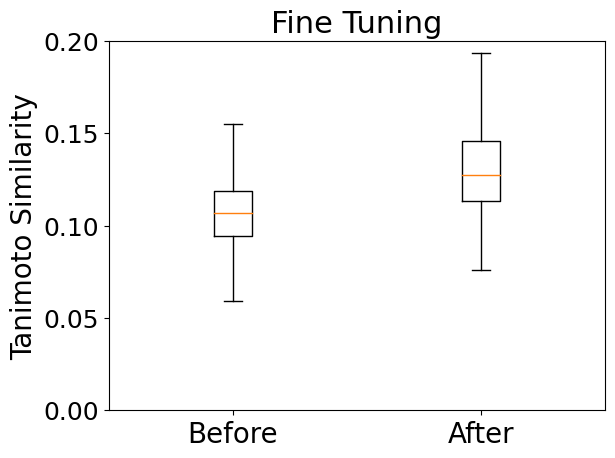

In [56]:
# Create plot of Tanimoto similarities for generated ligands before and after fine-tuning

seed = 'CCC1=CC(=CC=C1CN1CC(C1)C(O)=O)C(\C)=N\OCC1=CC=C(C2CCCCC2)C(=C1)C(F)(F)F'
pre_ligands = []
with open('pre_ligands.txt', 'r') as f:
    lines = f.read()
    lines = lines[:lines.rfind(',')]
    pre_ligands.extend(lines.split(',\n'))

post_ligands = []
with open('ligands.txt', 'r') as f:
    lines = f.read()
    lines = lines[:lines.rfind(',')]
    post_ligands.extend(lines.split(',\n'))

def tanimoto_similarities(seed, pre_ligands, post_ligands):

  pre_ligand_mols = [Chem.MolFromSmiles(smile) for smile in pre_ligands]
  post_ligand_mols = [Chem.MolFromSmiles(smile) for smile in post_ligands]

  pre_df = []
  post_df = []

  fig, ax = plt.subplots()
  mol1 = Chem.MolFromSmiles(seed)
  fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits = 2048)

  for mol2 in pre_ligand_mols:
      prefp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits = 2048)
      pre_df.append(DataStructs.TanimotoSimilarity(fp1, prefp2))

  for mol2 in post_ligand_mols:
      postfp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits = 2048)
      post_df.append(DataStructs.TanimotoSimilarity(fp1, postfp2))

  ax.boxplot([pre_df, post_df], labels = ['Before', 'After'], showfliers=False)
  ax.set_ylim(bottom=0)

  ax.set_title('Fine Tuning', fontsize = 22)
  ax.set_ylabel('Tanimoto Similarity', fontsize = 20)

  ax.tick_params(axis='x', labelsize=20)

  ax.tick_params(axis='y', labelsize=18)

  plt.show()

tanimoto_similarities(seed = seed, pre_ligands = pre_ligands, post_ligands = post_ligands)

100%|██████████| 462/462 [00:00<00:00, 2993.92it/s]


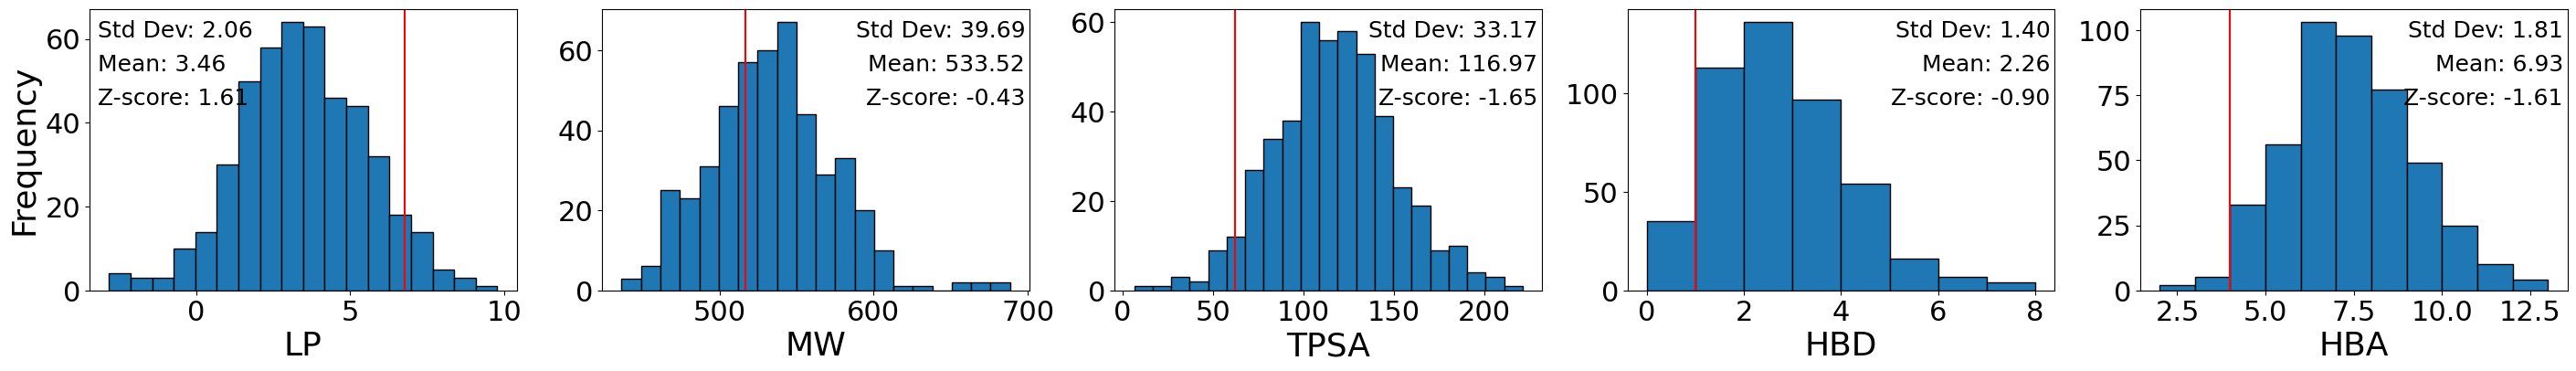

In [57]:
# Distribution of properties of generated ligands and property of target molecule

def ligand_distribution(property_funcs, seed):

  seed_ligand_mols = [Chem.MolFromSmiles(smile) for smile in pre_ligands]

  fig, axs = plt.subplots(nrows = 1, ncols = len(property_funcs), figsize = (len(property_funcs) * 7, 4), sharex = 'col')

  for k, func in enumerate(property_funcs):
    seed_ligand_props = []
    for mol in tqdm(seed_ligand_mols):
      try:
        seed_ligand_props.append(func(mol))
      except:
        pass

    if func == Lipinski.NumHDonors or func == Lipinski.NumHAcceptors:
      sns.histplot(seed_ligand_props, alpha = 1, ax = axs[k], binwidth = 1) # Larger binwidth for HBD and HBA because of limited discrete values
    else:
      sns.histplot(seed_ligand_props, alpha = 1, ax = axs[k])

    target_prop = func(Chem.MolFromSmiles(seed))
    red_line = axs[k].axvline(x=target_prop, color='red')

    if k == 0:
      axs[k].set_ylabel('Frequency', fontsize = 26)
    else:
      axs[k].set_ylabel('')

    axs[k].set_xlabel(["LP", "MW", "TPSA", "HBD", "HBA"][k], fontsize = 26)
    axs[k].tick_params(axis='x', labelsize=22)
    axs[k].tick_params(axis='y', labelsize=22)

    # Calculate standard deviation and mean
    std_dev = np.std(seed_ligand_props)
    mean_val = np.mean(seed_ligand_props)
    red_line_diff = (target_prop - mean_val) / std_dev

    if k == 0:
      axs[k].text(0.02, 0.9, f"Std Dev: {std_dev:.2f}", transform=axs[k].transAxes, ha='left', fontsize = 18)
      axs[k].text(0.02, 0.78, f"Mean: {mean_val:.2f}", transform=axs[k].transAxes, ha='left', fontsize = 18)
      axs[k].text(0.02, 0.66, f"Z-score: {red_line_diff:.2f}", transform=axs[k].transAxes, ha='left', fontsize = 18)
    else:
      axs[k].text(0.99, 0.9, f"Std Dev: {std_dev:.2f}", transform=axs[k].transAxes, ha='right', fontsize = 18)
      axs[k].text(0.99, 0.78, f"Mean: {mean_val:.2f}", transform=axs[k].transAxes, ha='right', fontsize = 18)
      axs[k].text(0.99, 0.66, f"Z-score: {red_line_diff:.2f}", transform=axs[k].transAxes, ha='right', fontsize = 18)

  plt.show();

ligand_distribution(property_funcs = [Descriptors.MolLogP, Descriptors.MolWt, Descriptors.TPSA, Lipinski.NumHDonors, Lipinski.NumHAcceptors], seed = seed)

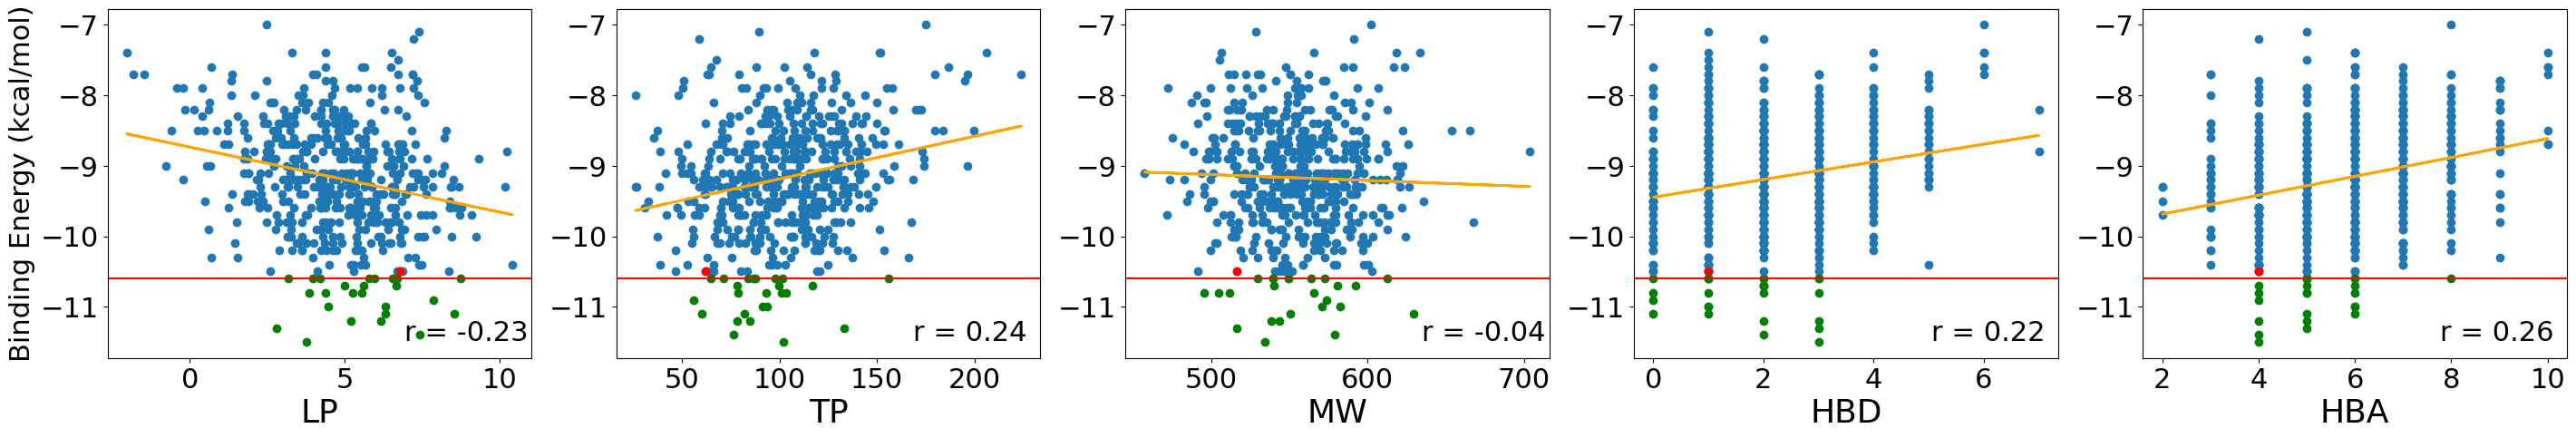

In [58]:
# Scatter plots evaluating relationship between molecular properties and binding affinity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

with open('ligand_dict.txt', 'r') as f:
    data = json.load(f)

smiles = list(data.keys())
energies = list(data.values())

seed = 'CCC1=CC(=CC=C1CN1CC(C1)C(O)=O)C(\C)=N\OCC1=CC=C(C2CCCCC2)C(=C1)C(F)(F)F'
siponimod_index = smiles.index(seed)

logPs = []
molecular_weights = []
tpsas = []
hbd = []
hba = []

for s in smiles:
    mol = Chem.MolFromSmiles(s)
    logP = Descriptors.MolLogP(mol)
    molecular_weight = Descriptors.MolWt(mol)
    tpsa = Descriptors.TPSA(mol)
    num_hbd = Descriptors.NumHDonors(mol)
    num_hba = Descriptors.NumHAcceptors(mol)
    logPs.append(logP)
    molecular_weights.append(molecular_weight)
    tpsas.append(tpsa)
    hbd.append(num_hbd)
    hba.append(num_hba)

fig, axs = plt.subplots(1, 5, figsize=(5*7, 5))

# Define the data sets
data_sets = [(logPs, 'LP'), (tpsas, 'TP'), (molecular_weights, 'MW'),
             (hbd, 'HBD'), (hba, 'HBA')]

# Scatter plot
for i, (data, label) in enumerate(data_sets):

    for x_val, y_val in zip(data,energies):
      color = 'green' if y_val <= -10.6 else '#1f77b4'
      axs[i].scatter(x_val, y_val, color=color)

    axs[i].scatter(data[siponimod_index], energies[siponimod_index], color='red')

    axs[i].set_xlabel(label, fontsize = 26)
    axs[i].axhline(-10.6, color='r')

    # Linear regression
    model = LinearRegression()
    model.fit(np.array(data).reshape(-1, 1), energies)
    predicted = model.predict(np.array(data).reshape(-1, 1))

    axs[i].plot(data, predicted, color='orange', linewidth=2)

    # Compute correlation coefficient
    r = np.corrcoef(data, energies)[0, 1]

    if i == 0 or i == 1:
      axs[i].annotate(f'r = {r:.2f}', xy=(0.70, 0.05),
                    xycoords='axes fraction', fontsize=22, color='black')
    else:
      axs[i].annotate(f'r = {r:.2f}', xy=(0.70, 0.05),
                    xycoords='axes fraction', fontsize=22, color='black')

axs[0].set_ylabel("Binding Energy (kcal/mol)", fontsize = 22)

for k in range(5):
  axs[k].tick_params(axis='x', labelsize=22)
  axs[k].tick_params(axis='y', labelsize=22)

plt.show()

High-affinity ligands


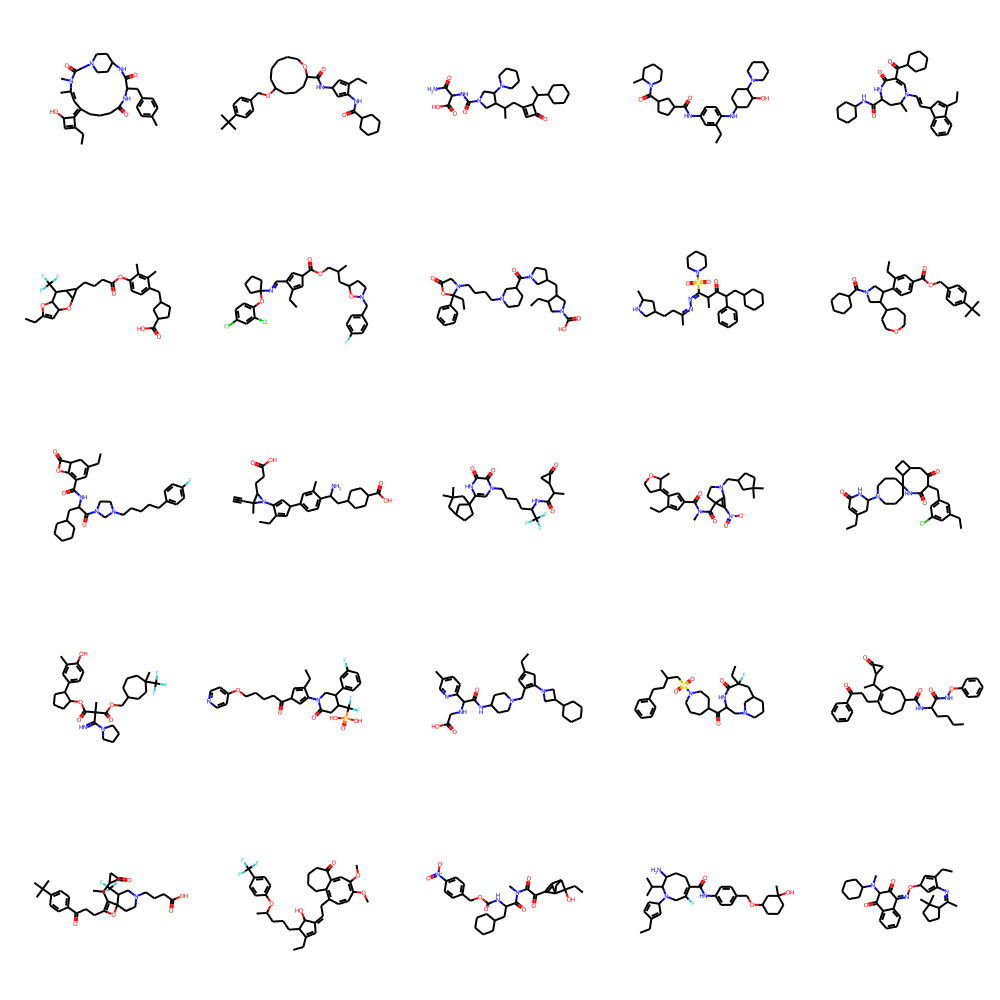

[-11.5, -11.4, -11.3, -11.2, -11.2, -11.1, -11.1, -11.0, -11.0, -10.9, -10.8, -10.8, -10.8, -10.8, -10.7, -10.7, -10.7, -10.6, -10.6, -10.6, -10.6, -10.6, -10.6, -10.6, -10.6]
[124, 69, 252, 237, 312, 316, 332, 39, 413, 109, 227, 359, 382, 532, 346, 420, 516, 17, 106, 126, 167, 226, 384, 399, 446]

Low-affinity ligands


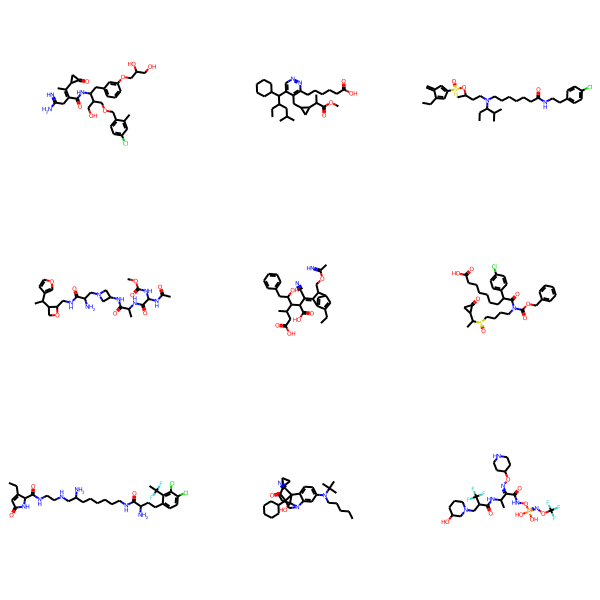

[-7.0, -7.1, -7.2, -7.4, -7.4, -7.4, -7.4, -7.5, -7.6]
[269, 206, 353, 158, 306, 350, 440, 395, 104]


In [59]:
# Find high and low-affinity ligands

with open('ligand_dict.txt', 'r') as f:
    data = json.load(f)

values = list(data.values())
keys = list(data.keys())

good_indices = heapq.nsmallest(25, range(len(values)), values.__getitem__)
good_values = [values[i] for i in good_indices]
good_mols = [Chem.MolFromSmiles(keys[i]) for i in good_indices]

bad_indices = heapq.nlargest(9, range(len(values)), values.__getitem__)
bad_values = [values[i] for i in bad_indices]
bad_mols = [Chem.MolFromSmiles(keys[i]) for i in bad_indices]

# Draw the molecules and display them, 10 molecules per row
print("High-affinity ligands")
display(Draw.MolsToGridImage(good_mols, molsPerRow=5))
print(good_values)
print(good_indices)

print("\nLow-affinity ligands")
display(Draw.MolsToGridImage(bad_mols, molsPerRow=3))
print(bad_values)
print(bad_indices)

100%|██████████| 1497/1497 [00:03<00:00, 384.90it/s]


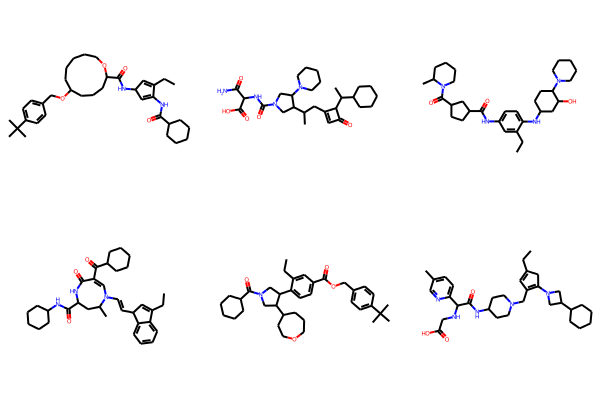

In [60]:
# Filter by SAS and QED metrics
import sascorer

drug_list = []
with open('drugs.txt', 'r') as file:
    for line in file.readlines()[1:]:
        parts = line.strip().split('\t')#r'TRUE|FALSE')
        if len(parts) == 3:
          drug_list.append(parts[2])

drug_scores = []
good_scores = []
drug_qeds = []
good_qeds = []

for smile in tqdm(drug_list):
  drug_scores.append(sascorer.calculateScore(Chem.MolFromSmiles(smile)))
for mol in good_mols:
  good_scores.append(sascorer.calculateScore(mol))
for smile in tqdm(drug_list):
  drug_qeds.append(Chem.QED.qed(Chem.MolFromSmiles(smile)))
for mol in good_mols:
  good_qeds.append(Chem.QED.qed(mol))

# Calculate the upper 50th percentile of QED scores and lower 50th percentile of SAS scores
upper_50th_qed = np.percentile(good_qeds, 50)
lower_50th_sas = np.percentile(good_scores, 50)

results = []
for mol in good_mols:
    if Chem.QED.qed(mol) >= upper_50th_qed and sascorer.calculateScore(mol) <= lower_50th_sas:
        results.append(mol)

# Display filtered molecules
display(Draw.MolsToGridImage(results, molsPerRow=3))

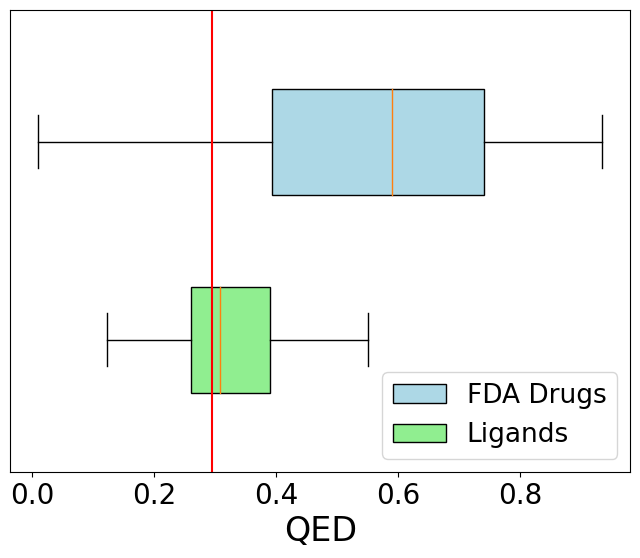

In [61]:
# QED distribution

seed = 'CCC1=CC(=CC=C1CN1CC(C1)C(O)=O)C(\C)=N\OCC1=CC=C(C2CCCCC2)C(=C1)C(F)(F)F'

fig, ax = plt.subplots(figsize=(8, 6))

boxplot_positions = [1.25, 2]

# Create horizontal boxplots
boxplot = ax.boxplot([good_qeds, drug_qeds], widths = 0.4, vert=False, patch_artist=True, positions=boxplot_positions)

colors = ['lightgreen', 'lightblue']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xlabel('QED')
ax.set_yticks([])

# Add a legend
ax.legend([boxplot["boxes"][1], boxplot["boxes"][0]], ['FDA Drugs', 'Ligands'], loc='lower right', fontsize = 19)

# Draw a vertical line for the seed molecule's QED
ax.axvline(x=Chem.QED.qed(Chem.MolFromSmiles(seed)), color='red')

ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("QED", fontsize=24)
plt.show()


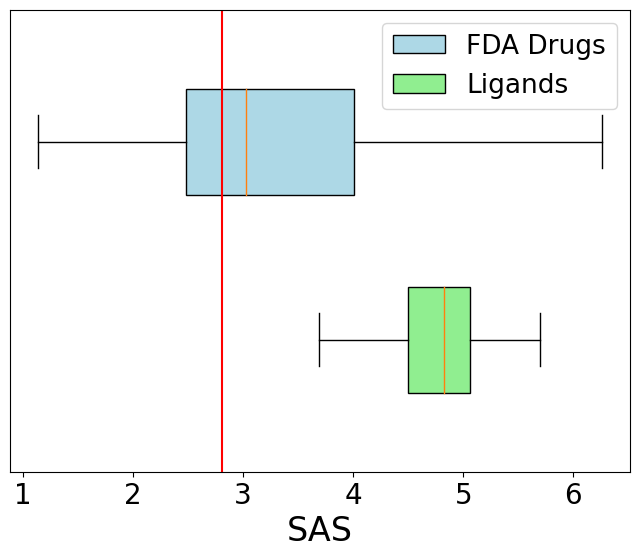

In [62]:
# SAS distribution

fig, ax = plt.subplots(figsize=(8, 6))

boxplot_positions = [1.25, 2]

# Create horizontal boxplots
boxplot = ax.boxplot([good_scores, drug_scores], widths = 0.4, vert=False, showfliers = False, patch_artist=True, positions=boxplot_positions)

colors = ['lightgreen', 'lightblue']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xlabel('SAS')
ax.set_yticks([])

# Add a legend
ax.legend([boxplot["boxes"][1], boxplot["boxes"][0]], ['FDA Drugs', 'Ligands'], loc='upper right', fontsize = 19)

# Draw a vertical line for the seed molecule's QED
ax.axvline(x=sascorer.calculateScore(Chem.MolFromSmiles(seed)), color='red')

ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("SAS", fontsize=24)
plt.show()


In [63]:
# Create table analyzing binding affinity, SAS, QED, and Lipinski's Rule of Five for high-affinity ligands

# Add siponimod row
good_mols.append(Chem.MolFromSmiles(seed))
good_values.append(-10.6)
good_scores.append(sascorer.calculateScore(Chem.MolFromSmiles(seed)))
good_qeds.append(Chem.QED.qed(Chem.MolFromSmiles(seed)))

def lipinski_rule_five(mols):

    df = pd.DataFrame(columns=['SMILES', 'Binding Affinity', 'SAS', 'QED', 'MolWt', 'LogP', 'HBD', 'HBA'])
    codes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Sip']

    for i, mol in enumerate(mols):

        # Calculate Lipinski Rule of Five values using RDKit Descriptors
        mol_wt = Descriptors.MolWt(mol)
        log_p = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)

        # Create a dictionary with the SMILES string and Lipinski Rule of Five values
        data = {'SMILES': codes[i], 'Binding Affinity': good_values[i], 'SAS': good_scores[i], 'QED': good_qeds[i], 'MolWt': mol_wt, 'LogP': log_p, 'HBD': hbd, 'HBA': hba}
        df = df.append(data, ignore_index=True)

    return df

display(lipinski_rule_five(good_mols))
lipinski_rule_five(good_mols).to_csv('sample.csv', index=False)

<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

,SMILES,Binding Affinity,SAS,QED,MolWt,LogP,HBD,HBA
0,A,-11.5,5.363102,0.549775,534.701,3.74992,3,4
1,B,-11.4,4.438564,0.336699,578.838,7.41400,2,4
2,C,-11.3,4.752702,0.403750,516.683,2.78870,3,5
3,D,-11.2,4.074250,0.445272,538.777,5.18460,3,5
4,E,-11.2,4.512340,0.404389,543.752,6.15210,2,4
5,F,-11.1,5.058020,0.286831,550.614,6.30714,1,5
6,G,-11.1,4.825726,0.174083,629.600,8.52050,0,6
7,H,-11.0,4.496623,0.303914,582.786,4.47500,1,6
8,I,-11.0,4.546202,0.191630,570.844,6.31410,1,6
9,J,-10.9,3.688290,0.316729,573.818,7.84250,0,4


<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)
<ipython-input-63-df84d9d09493>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

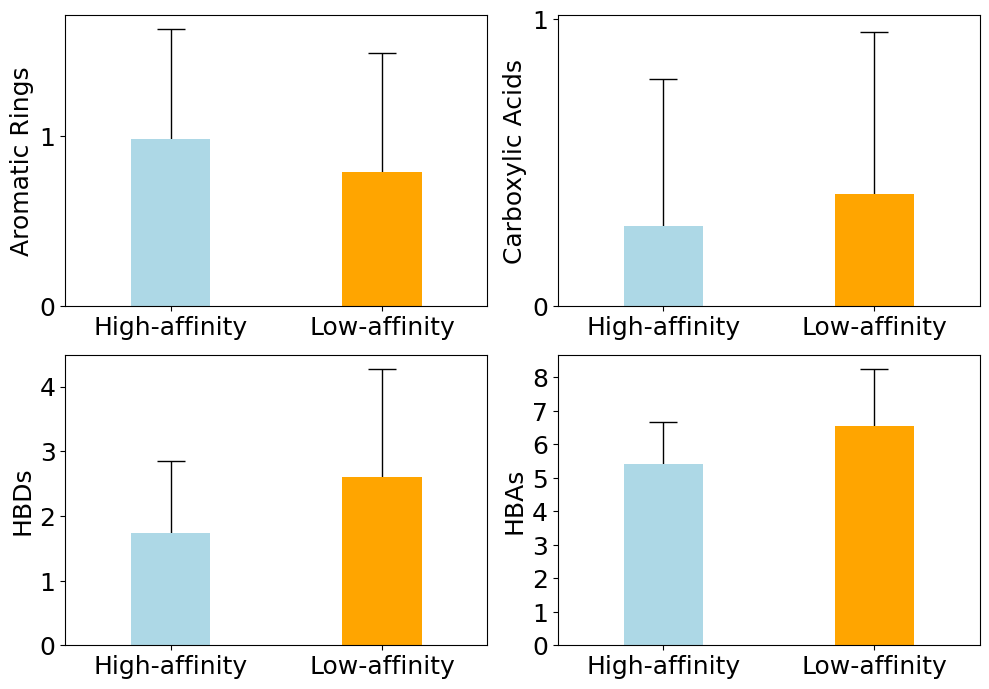

In [64]:
# Create plot of aromatic rings distribution for high and low-affinity ligands
from matplotlib.ticker import MaxNLocator

# Reading ligand dictionary
with open('ligand_dict.txt', 'r') as f:
    data = json.load(f)

values = list(data.values()) # Binding energies
keys = list(data.keys()) # SMILES

best_100_indices = heapq.nsmallest(100, range(len(values)), values.__getitem__)
best_100_mols = [Chem.MolFromSmiles(keys[i]) for i in best_100_indices]

worst_100_indices = heapq.nlargest(100, range(len(values)), values.__getitem__)
worst_100_mols = [Chem.MolFromSmiles(keys[i]) for i in worst_100_indices]

best_aromatic_ring_counts = [sum([1 for ring in mol.GetRingInfo().AtomRings() if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring)]) for mol in best_100_mols]
worst_aromatic_ring_counts = [sum([1 for ring in mol.GetRingInfo().AtomRings() if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring)]) for mol in worst_100_mols]

best_acid_counts = [Fragments.fr_COO(mol) for mol in best_100_mols]
worst_acid_counts = [Fragments.fr_COO(mol) for mol in worst_100_mols]

best_HBD_counts = [Descriptors.NumHDonors(mol) for mol in best_100_mols]
worst_HBD_counts = [Descriptors.NumHDonors(mol) for mol in worst_100_mols]

best_HBA_counts = [Descriptors.NumHAcceptors(mol) for mol in best_100_mols]
worst_HBA_counts = [Descriptors.NumHAcceptors(mol) for mol in worst_100_mols]

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

# Properties
properties = ["Aromatic Rings", "Carboxylic Acids", "HBDs", "HBAs"]
colors = ['lightblue', 'orange']
bar_width = 0.15

data_high_affinity = [best_aromatic_ring_counts, best_acid_counts, best_HBD_counts, best_HBA_counts]
data_low_affinity = [worst_aromatic_ring_counts, worst_acid_counts, worst_HBD_counts, worst_HBA_counts]

for i, ax in enumerate(axs.flatten()):
    # Calculate the mean and standard deviation of the datasets
    mean_high = np.mean(data_high_affinity[i])
    std_high = np.std(data_high_affinity[i])

    mean_low = np.mean(data_low_affinity[i])
    std_low = np.std(data_low_affinity[i])

    ax.errorbar(0.3, mean_high, yerr=std_high, fmt='none', color='black', capsize=10, elinewidth=1, zorder=1)
    ax.errorbar(0.7, mean_low, yerr=std_low, fmt='none', color='black', capsize=10, elinewidth=1, zorder=1)

    ax.bar(0.3, mean_high, width=bar_width, color=colors[0], label='High-affinity', zorder=2)
    ax.bar(0.7, mean_low, width=bar_width, color=colors[1], label='Low-affinity', zorder=2)

    ax.set_xticks([0.3, 0.7])
    ax.set_xticklabels(['High-affinity', 'Low-affinity'])
    ax.set_ylabel(properties[i], fontsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlim([0.1, 0.9])
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

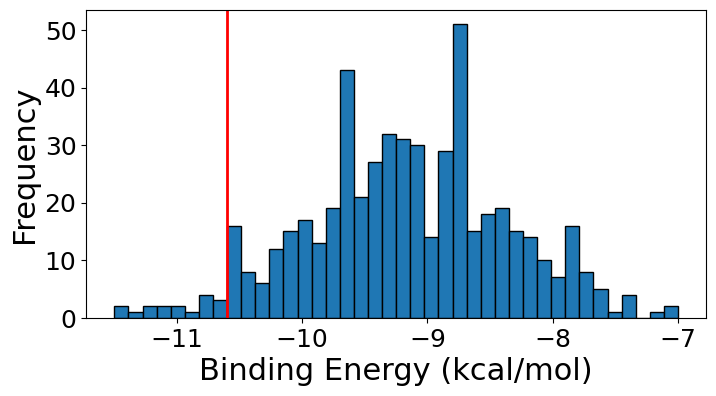

In [65]:
# Histogram of binding energies

values = list(data.values())  # Binding energies
keys = list(data.keys())  # SMILES

# Binding energy of siponimod
siponimod_energy = -10.6

# Create the histogram
plt.figure(figsize=(8, 4))
plt.hist(values, bins=40, edgecolor='black')
plt.axvline(x=siponimod_energy, color='r', linewidth=2)
plt.xlabel('Binding Energy (kcal/mol)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 22)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.show()

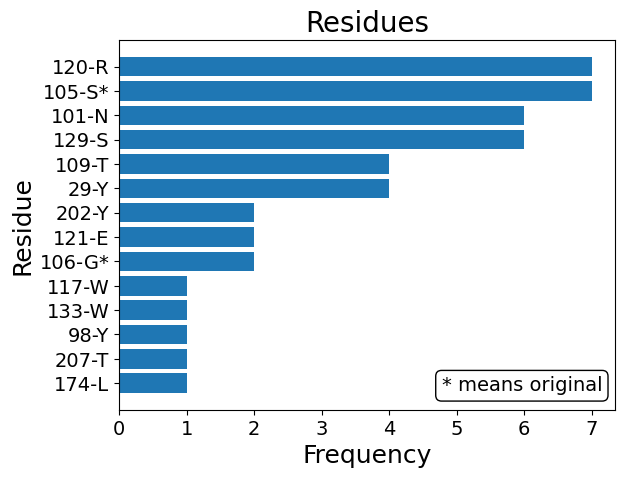

In [37]:
# Create frequency histogram of residues

data = {
    '105-S*': 7,
    '120-R': 7,
    '129-S': 6,
    '101-N': 6,
    '29-Y': 4,
    '109-T': 4,
    '106-G*': 2,
    '121-E': 2,
    '202-Y': 2,
    '174-L': 1,
    '207-T': 1,
    '98-Y': 1,
    '133-W': 1,
    '117-W': 1
}

# Sort the data by values in descending order
sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=False)

# Extract labels and counts
labels, counts = zip(*sorted_data)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the horizontal bars
ax.barh(range(len(labels)), counts, align='center')

# Set the labels for each bar
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)

box_text = '* means original'
ax.text(0.65, 0.05, box_text, fontsize = 14, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel("Residue", fontsize = 18)
ax.set_xlabel("Frequency", fontsize = 18)
ax.set_title("Residues", fontsize = 20)

# Display the plot
plt.show()